### Assignment for submission number 2
* Name: Ofek Biton
* ID: 209062264

In [20]:
import pandas as pd
import numpy as np
import re
import os 
import datetime
from datetime import datetime

In [21]:
file = 'matala2_cosmetics_2019-Nov.csv'
Data = pd.read_csv(file)
## example of using slice from the data
Data = Data[0:150000].drop(['brand','category_code','category_id'], axis=1)
Data.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10404\3733127204.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  Data = pd.read_csv(file)


,event_time,event_type,product_id,price,user_id,user_session
0,2019-11-01 00:00:02 UTC,view,5802432,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
1,2019-11-01 00:00:09 UTC,cart,5844397,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
2,2019-11-01 00:00:10 UTC,view,5837166,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
3,2019-11-01 00:00:11 UTC,cart,5876812,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7
4,2019-11-01 00:00:24 UTC,remove_from_cart,5826182,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb


### Question 1:

In [22]:
df_q1 = Data.copy()
df_q1['event_date'] = df_q1['event_time'].apply(lambda x: datetime.strptime(x.split(' ')[0], '%Y-%m-%d'))
# convert event time column to datetime format. 
df_q1['event_time'] = pd.to_datetime(Data['event_time'])
# sort the dataframe by user_id, user_session, and event time columns.
df_q1 = df_q1.sort_values(['user_id', 'user_session', 'event_time'])
# group the events by user_id and user_session so i can calculate for eache user.
grouped = df_q1.groupby(['user_id', 'user_session'])
# calculate the time difference in seconds between each event and the next event in the same session
df_q1['duration_to_next_event'] = grouped['event_time'].diff(periods=-1).dt.total_seconds()
df_q1['duration_to_next_event'] = abs(df_q1['duration_to_next_event'])
# set the value of duration_to_next_event to 0 for the last event in each session.
last_events = grouped.tail(1).index
df_q1.loc[last_events, 'duration_to_next_event'] = 0
df_q1.head()

,event_time,event_type,product_id,price,user_id,user_session,event_date,duration_to_next_event
44711,2019-11-01 11:16:58+00:00,view,5866215,8.79,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,88.0
44881,2019-11-01 11:18:26+00:00,cart,5899429,6.75,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,2.0
44882,2019-11-01 11:18:28+00:00,cart,5899431,11.44,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,13.0
44908,2019-11-01 11:18:41+00:00,cart,5899426,12.73,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,2.0
44913,2019-11-01 11:18:43+00:00,cart,5899427,17.63,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,23.0


### Question 2:

In [23]:
from datetime import datetime

df_q2 = df_q1.copy()

# df_q2['event_date'] = df_q2['event_time'].apply(lambda x: datetime.strptime(x.split(' ')[0], '%Y-%m-%d'))

df_q2 = df_q2[['user_id','event_date', 'user_session']].drop_duplicates().sort_values(['user_id','event_date'])

df_q2['diff'] = (df_q2.groupby('user_id')['event_date'].diff() / np.timedelta64(1, 'D')).fillna(0.0)

df_q2['diff5plus'] = df_q2['diff'].apply(lambda x: 0 if x <= 5 else 1)

df_q2['funnel_number'] = df_q2.groupby('user_id')['diff5plus'].cumsum() + 1 #  +1 change funnel number range from [0:x-1] to [1:x]
df_q2 = df_q2[['user_id', 'event_date', 'user_session', 'funnel_number']]
df_q2 = pd.merge(df_q1, df_q2, on=['user_id', 'event_date', 'user_session'], how='left')
df_q2

,event_time,event_type,product_id,price,user_id,user_session,event_date,duration_to_next_event,funnel_number
0,2019-11-01 11:16:58+00:00,view,5866215,8.79,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,88.0,1
1,2019-11-01 11:18:26+00:00,cart,5899429,6.75,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,2.0,1
2,2019-11-01 11:18:28+00:00,cart,5899431,11.44,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,13.0,1
3,2019-11-01 11:18:41+00:00,cart,5899426,12.73,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,2.0,1
4,2019-11-01 11:18:43+00:00,cart,5899427,17.63,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,23.0,1
...,...,...,...,...,...,...,...,...,...
149995,2019-11-02 10:17:12+00:00,view,5848761,26.83,566738422,ff7ea14f-791e-4745-8f6d-7958894d4a42,2019-11-02,0.0,1
149996,2019-11-02 10:17:18+00:00,view,89343,299.81,566738449,46f83841-efc3-4bf8-b18b-083492837823,2019-11-02,0.0,1
149997,2019-11-02 10:17:31+00:00,view,5649270,6.19,566738452,67e7ff0f-66fb-48dc-a545-fee612f677c9,2019-11-02,0.0,1
149998,2019-11-02 10:17:21+00:00,view,5769919,3.65,566738462,f9cec92d-bec3-45d6-9223-93ac43d06100,2019-11-02,0.0,1


### Question 3:

In [24]:
df_q3 = df_q2.copy()
df_q3['index_in_funnel'] = [1]*df_q3.shape[0]
df_q3['index_in_funnel'] = df_q3.groupby(['user_id', 'funnel_number'])['index_in_funnel'].cumsum()
df_q3

,event_time,event_type,product_id,price,user_id,user_session,event_date,duration_to_next_event,funnel_number,index_in_funnel
0,2019-11-01 11:16:58+00:00,view,5866215,8.79,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,88.0,1,1
1,2019-11-01 11:18:26+00:00,cart,5899429,6.75,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,2.0,1,2
2,2019-11-01 11:18:28+00:00,cart,5899431,11.44,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,13.0,1,3
3,2019-11-01 11:18:41+00:00,cart,5899426,12.73,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,2.0,1,4
4,2019-11-01 11:18:43+00:00,cart,5899427,17.63,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,23.0,1,5
...,...,...,...,...,...,...,...,...,...,...
149995,2019-11-02 10:17:12+00:00,view,5848761,26.83,566738422,ff7ea14f-791e-4745-8f6d-7958894d4a42,2019-11-02,0.0,1,1
149996,2019-11-02 10:17:18+00:00,view,89343,299.81,566738449,46f83841-efc3-4bf8-b18b-083492837823,2019-11-02,0.0,1,1
149997,2019-11-02 10:17:31+00:00,view,5649270,6.19,566738452,67e7ff0f-66fb-48dc-a545-fee612f677c9,2019-11-02,0.0,1,1
149998,2019-11-02 10:17:21+00:00,view,5769919,3.65,566738462,f9cec92d-bec3-45d6-9223-93ac43d06100,2019-11-02,0.0,1,1


### Question 4:

In [25]:
# Apply the extract_price function to each row of the 'price' column
df_q4 = df_q3.copy()
df_q4['price'] = df_q4['price'].astype(str).apply(lambda x: re.sub('[^\d\.]', '', x))
df_q4

,event_time,event_type,product_id,price,user_id,user_session,event_date,duration_to_next_event,funnel_number,index_in_funnel
0,2019-11-01 11:16:58+00:00,view,5866215,8.79,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,88.0,1,1
1,2019-11-01 11:18:26+00:00,cart,5899429,6.75,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,2.0,1,2
2,2019-11-01 11:18:28+00:00,cart,5899431,11.44,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,13.0,1,3
3,2019-11-01 11:18:41+00:00,cart,5899426,12.73,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,2.0,1,4
4,2019-11-01 11:18:43+00:00,cart,5899427,17.63,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,23.0,1,5
...,...,...,...,...,...,...,...,...,...,...
149995,2019-11-02 10:17:12+00:00,view,5848761,26.83,566738422,ff7ea14f-791e-4745-8f6d-7958894d4a42,2019-11-02,0.0,1,1
149996,2019-11-02 10:17:18+00:00,view,89343,299.81,566738449,46f83841-efc3-4bf8-b18b-083492837823,2019-11-02,0.0,1,1
149997,2019-11-02 10:17:31+00:00,view,5649270,6.19,566738452,67e7ff0f-66fb-48dc-a545-fee612f677c9,2019-11-02,0.0,1,1
149998,2019-11-02 10:17:21+00:00,view,5769919,3.65,566738462,f9cec92d-bec3-45d6-9223-93ac43d06100,2019-11-02,0.0,1,1


### Question 5:

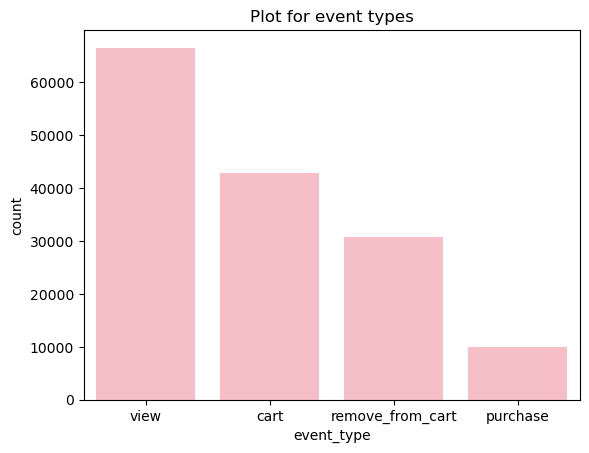

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='event_type', data=Data, color = "lightpink");
plt.title('Plot for event types');

### Question 6:

#### 6e:

In [27]:
# session_data[session_data['user_session']=='9a11e19f-ef90-493d-a555-99899dd9be2c']

In [28]:
df_q6_e = df_q4.copy()
df_q6_e['Num_of_events'] = df_q6_e.groupby(['user_id', 'user_session'])['event_type'].transform('count')
df_q6_e = df_q6_e.drop_duplicates(subset=['user_id', 'user_session'], keep='first')
df_q6_e

,event_time,event_type,product_id,price,user_id,user_session,event_date,duration_to_next_event,funnel_number,index_in_funnel,Num_of_events
0,2019-11-01 11:16:58+00:00,view,5866215,8.79,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,88.0,1,1,7.0
7,2019-11-02 06:22:30+00:00,remove_from_cart,5813473,3.95,20554973,e6f2e7c1-1060-4e8f-87eb-80c85cf2fd48,2019-11-02,68.0,1,1,3.0
10,2019-11-01 18:41:04+00:00,cart,5752494,4.27,28048440,42b6ab74-2ed2-4237-8f69-b55ec92a236a,2019-11-01,23.0,1,1,5.0
15,2019-11-02 04:16:42+00:00,view,5752483,4.27,28048440,c50c5088-babf-4bf4-b125-39981044c152,2019-11-02,24.0,1,6,2.0
17,2019-11-01 13:08:03+00:00,remove_from_cart,5785422,3.16,31272873,dceb4d25-8bbe-45ee-a619-8f201664a826,2019-11-01,0.0,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,2019-11-02 10:17:12+00:00,view,5848761,26.83,566738422,ff7ea14f-791e-4745-8f6d-7958894d4a42,2019-11-02,0.0,1,1,1.0
149996,2019-11-02 10:17:18+00:00,view,89343,299.81,566738449,46f83841-efc3-4bf8-b18b-083492837823,2019-11-02,0.0,1,1,1.0
149997,2019-11-02 10:17:31+00:00,view,5649270,6.19,566738452,67e7ff0f-66fb-48dc-a545-fee612f677c9,2019-11-02,0.0,1,1,1.0
149998,2019-11-02 10:17:21+00:00,view,5769919,3.65,566738462,f9cec92d-bec3-45d6-9223-93ac43d06100,2019-11-02,0.0,1,1,1.0


#### 6f:

In [29]:
df_q6_f = df_q4.copy()
df_q6_f['total_time'] = df_q6_f.groupby(['user_id', 'user_session'])['duration_to_next_event'].transform('sum')
df_q6_f = df_q6_f.drop_duplicates(subset=['user_id', 'user_session'], keep='first')
df_q6_f

,event_time,event_type,product_id,price,user_id,user_session,event_date,duration_to_next_event,funnel_number,index_in_funnel,total_time
0,2019-11-01 11:16:58+00:00,view,5866215,8.79,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,88.0,1,1,496.0
7,2019-11-02 06:22:30+00:00,remove_from_cart,5813473,3.95,20554973,e6f2e7c1-1060-4e8f-87eb-80c85cf2fd48,2019-11-02,68.0,1,1,127.0
10,2019-11-01 18:41:04+00:00,cart,5752494,4.27,28048440,42b6ab74-2ed2-4237-8f69-b55ec92a236a,2019-11-01,23.0,1,1,375.0
15,2019-11-02 04:16:42+00:00,view,5752483,4.27,28048440,c50c5088-babf-4bf4-b125-39981044c152,2019-11-02,24.0,1,6,24.0
17,2019-11-01 13:08:03+00:00,remove_from_cart,5785422,3.16,31272873,dceb4d25-8bbe-45ee-a619-8f201664a826,2019-11-01,0.0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,2019-11-02 10:17:12+00:00,view,5848761,26.83,566738422,ff7ea14f-791e-4745-8f6d-7958894d4a42,2019-11-02,0.0,1,1,0.0
149996,2019-11-02 10:17:18+00:00,view,89343,299.81,566738449,46f83841-efc3-4bf8-b18b-083492837823,2019-11-02,0.0,1,1,0.0
149997,2019-11-02 10:17:31+00:00,view,5649270,6.19,566738452,67e7ff0f-66fb-48dc-a545-fee612f677c9,2019-11-02,0.0,1,1,0.0
149998,2019-11-02 10:17:21+00:00,view,5769919,3.65,566738462,f9cec92d-bec3-45d6-9223-93ac43d06100,2019-11-02,0.0,1,1,0.0


#### 6g:

In [30]:
df_q6_g = df_q4.copy()
df_q6_g = df_q6_g[df_q6_g['event_type'] == 'view']
df_q6_g['list_of_viewed'] = df_q6_g.groupby(['user_id','user_session'])['product_id'].transform(lambda x : [x.tolist()]*len(x))
df_q6_g = df_q6_g.drop_duplicates(subset=['user_id', 'user_session'], keep='first')
df_q6_g

,event_time,event_type,product_id,price,user_id,user_session,event_date,duration_to_next_event,funnel_number,index_in_funnel,list_of_viewed
0,2019-11-01 11:16:58+00:00,view,5866215,8.79,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,88.0,1,1,"[5866215, 5899429]"
12,2019-11-01 18:42:01+00:00,view,5770522,3.89,28048440,42b6ab74-2ed2-4237-8f69-b55ec92a236a,2019-11-01,313.0,1,3,"[5770522, 5752483]"
15,2019-11-02 04:16:42+00:00,view,5752483,4.27,28048440,c50c5088-babf-4bf4-b125-39981044c152,2019-11-02,24.0,1,6,"[5752483, 5752483]"
27,2019-11-01 20:14:26+00:00,view,5695944,1.43,34033932,056101ec-67ff-4e61-a4c2-dc6d3a450080,2019-11-01,49.0,1,10,[5695944]
59,2019-11-02 00:07:26+00:00,view,5899841,4.02,34236465,3e515cc4-aa97-4cdf-a438-3b28a63b0ffc,2019-11-02,0.0,1,13,[5899841]
...,...,...,...,...,...,...,...,...,...,...,...
149995,2019-11-02 10:17:12+00:00,view,5848761,26.83,566738422,ff7ea14f-791e-4745-8f6d-7958894d4a42,2019-11-02,0.0,1,1,[5848761]
149996,2019-11-02 10:17:18+00:00,view,89343,299.81,566738449,46f83841-efc3-4bf8-b18b-083492837823,2019-11-02,0.0,1,1,[89343]
149997,2019-11-02 10:17:31+00:00,view,5649270,6.19,566738452,67e7ff0f-66fb-48dc-a545-fee612f677c9,2019-11-02,0.0,1,1,[5649270]
149998,2019-11-02 10:17:21+00:00,view,5769919,3.65,566738462,f9cec92d-bec3-45d6-9223-93ac43d06100,2019-11-02,0.0,1,1,[5769919]


#### 6h:

In [31]:
df_q6_h = df_q4.copy()
df_q6_h = df_q6_h[df_q6_h['event_type'] == 'cart']
df_q6_h['list_of_added_to_cart'] = df_q6_h.groupby(['user_id','user_session'])['product_id'].transform(lambda x : [x.tolist()]*len(x))
df_q6_h = df_q6_h.drop_duplicates(subset=['user_id', 'user_session'], keep='first')
df_q6_h

,event_time,event_type,product_id,price,user_id,user_session,event_date,duration_to_next_event,funnel_number,index_in_funnel,list_of_added_to_cart
1,2019-11-01 11:18:26+00:00,cart,5899429,6.75,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,2019-11-01,2.0,1,2,"[5899429, 5899431, 5899426, 5899427, 5899428]"
10,2019-11-01 18:41:04+00:00,cart,5752494,4.27,28048440,42b6ab74-2ed2-4237-8f69-b55ec92a236a,2019-11-01,23.0,1,1,"[5752494, 5649279]"
18,2019-11-01 20:12:36+00:00,cart,5809243,1.59,34033932,056101ec-67ff-4e61-a4c2-dc6d3a450080,2019-11-01,12.0,1,1,"[5809243, 5851099, 5809247, 5848415, 5777205, ..."
47,2019-11-02 00:00:27+00:00,cart,5802437,4.92,34236465,3e515cc4-aa97-4cdf-a438-3b28a63b0ffc,2019-11-02,241.0,1,1,[5802437]
62,2019-11-01 20:12:19+00:00,cart,5819634,21.57,38741280,d1aea30d-63da-42dc-ad75-87c768252669,2019-11-01,16.0,1,2,"[5819634, 5804023, 5819634, 5652774, 5824810, ..."
...,...,...,...,...,...,...,...,...,...,...,...
149935,2019-11-02 10:12:32+00:00,cart,5757580,4.27,566736623,db069902-91bf-4aa8-a5b3-9cd8f9cf5d7e,2019-11-02,94.0,1,1,"[5757580, 5861102, 5861111, 5801032]"
149944,2019-11-02 10:14:26+00:00,cart,5780829,7.14,566736726,0bcc8b9d-a8d8-4167-875c-4e503f9e3022,2019-11-02,0.0,1,1,"[5780829, 5780829, 5780829]"
149950,2019-11-02 10:16:20+00:00,cart,5811798,1.73,566736799,1e1275e8-3163-4530-a0ca-1d1e4c28744f,2019-11-02,15.0,1,1,"[5811798, 5796979, 5796994]"
149961,2019-11-02 10:17:03+00:00,cart,5861729,7.14,566737093,2334614b-4ee4-4058-8171-635937f5b200,2019-11-02,23.0,1,2,"[5861729, 5842621]"


#### 6i:

In [32]:
df_q6_i = df_q4.copy()
df_q6_i = df_q6_i[df_q6_i['event_type'] == 'purchase']
df_q6_i['list_of_purchased'] = df_q6_i.groupby(['user_id','user_session'])['product_id'].transform(lambda x : [x.tolist()]*len(x))
df_q6_i = df_q6_i.drop_duplicates(subset=['user_id', 'user_session'], keep='first')
df_q6_i

,event_time,event_type,product_id,price,user_id,user_session,event_date,duration_to_next_event,funnel_number,index_in_funnel,list_of_purchased
48,2019-11-02 00:04:28+00:00,purchase,89350,1.27,34236465,3e515cc4-aa97-4cdf-a438-3b28a63b0ffc,2019-11-02,0.0,1,2,"[89350, 5844670, 5842876, 5802437, 5763238, 57..."
316,2019-11-01 06:45:13+00:00,purchase,5853321,8.97,104368191,d0ec1a85-6f1b-487f-951d-3eab39a1048d,2019-11-01,0.0,1,38,"[5853321, 5869577, 5887687, 5896018]"
335,2019-11-01 10:42:44+00:00,purchase,5705001,3.33,104808268,390c3cf3-2fee-4a24-bf1e-c79dd3b33dd2,2019-11-01,0.0,1,15,"[5705001, 5730214, 5796819, 5802432, 5900651]"
468,2019-11-01 13:34:49+00:00,purchase,5841195,47.59,129089988,1d491fc1-ad7e-4ae9-bdc5-dbc26c70dd11,2019-11-01,0.0,1,3,[5841195]
575,2019-11-02 07:36:57+00:00,purchase,5784117,2.84,162807077,dd67e33d-7ec2-4220-a903-0a9ef8e2635f,2019-11-02,0.0,1,63,"[5784117, 5742717, 5830545, 5834649, 5837609, ..."
...,...,...,...,...,...,...,...,...,...,...,...
149324,2019-11-02 10:00:16+00:00,purchase,4958,1.19,566723997,68d77506-60fe-4601-acdc-9728e6a0f90e,2019-11-02,0.0,1,47,"[4958, 5882556, 4902, 5570252, 5746636, 575850..."
149482,2019-11-02 10:14:42+00:00,purchase,5785608,0.79,566726302,9d42f256-7658-48fc-bd4c-a8d419e0964a,2019-11-02,0.0,1,17,"[5785608, 5809237, 5809259, 5809295, 5809302, ..."
149639,2019-11-02 09:52:34+00:00,purchase,5763380,4.6,566729205,94478cf5-0fa0-4df6-805f-ccc81a3618d5,2019-11-02,0.0,1,5,[5763380]
149819,2019-11-02 10:09:39+00:00,purchase,5814523,4.44,566733694,ae68256d-a527-4195-98eb-9e326f9f9e51,2019-11-02,0.0,1,1,"[5814523, 5857045, 5859451, 5875295, 5891030]"


In [33]:
merged = pd.merge(
df_q6_e[['user_id', 'user_session', 'Num_of_events']],
df_q6_f[['user_id', 'user_session', 'total_time']],
    on = ['user_id', 'user_session'], how='left')
merged = pd.merge(merged,
df_q6_g[['user_id', 'user_session', 'list_of_viewed']],
    on = ['user_id', 'user_session'], how='left')
merged = pd.merge(merged,
df_q6_h[['user_id', 'user_session', 'list_of_added_to_cart']],
    on = ['user_id', 'user_session'], how='left')
merged = pd.merge(merged,
df_q6_i[['user_id', 'user_session', 'list_of_purchased']],
    on = ['user_id', 'user_session'], how='left')
session_data = merged = pd.merge(merged,
df_q4[['user_id', 'user_session', 'funnel_number','index_in_funnel']],
    on = ['user_id', 'user_session'], how='left')
session_data

,user_id,user_session,Num_of_events,total_time,list_of_viewed,list_of_added_to_cart,list_of_purchased,funnel_number,index_in_funnel
0,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",NaN,1,1
1,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",NaN,1,2
2,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",NaN,1,3
3,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",NaN,1,4
4,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",NaN,1,5
...,...,...,...,...,...,...,...,...,...
149995,566738422,ff7ea14f-791e-4745-8f6d-7958894d4a42,1.0,0.0,[5848761],NaN,NaN,1,1
149996,566738449,46f83841-efc3-4bf8-b18b-083492837823,1.0,0.0,[89343],NaN,NaN,1,1
149997,566738452,67e7ff0f-66fb-48dc-a545-fee612f677c9,1.0,0.0,[5649270],NaN,NaN,1,1
149998,566738462,f9cec92d-bec3-45d6-9223-93ac43d06100,1.0,0.0,[5769919],NaN,NaN,1,1


In [34]:
merged['Num_of_events'] = merged['Num_of_events'].fillna(0.0)
merged['total_time'] = merged['total_time'].fillna(0.0)
merged['list_of_viewed'] = merged['list_of_viewed'].fillna("").apply(list)
merged['list_of_added_to_cart'] = merged['list_of_added_to_cart'].fillna("").apply(list)
merged['list_of_purchased'] = merged['list_of_purchased'].fillna("").apply(list)
session_data

,user_id,user_session,Num_of_events,total_time,list_of_viewed,list_of_added_to_cart,list_of_purchased,funnel_number,index_in_funnel
0,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",[],1,1
1,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",[],1,2
2,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",[],1,3
3,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",[],1,4
4,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",[],1,5
...,...,...,...,...,...,...,...,...,...
149995,566738422,ff7ea14f-791e-4745-8f6d-7958894d4a42,1.0,0.0,[5848761],[],[],1,1
149996,566738449,46f83841-efc3-4bf8-b18b-083492837823,1.0,0.0,[89343],[],[],1,1
149997,566738452,67e7ff0f-66fb-48dc-a545-fee612f677c9,1.0,0.0,[5649270],[],[],1,1
149998,566738462,f9cec92d-bec3-45d6-9223-93ac43d06100,1.0,0.0,[5769919],[],[],1,1


In [35]:
session_data = session_data.drop_duplicates(subset=['user_id', 'user_session'], keep='first')
session_data

,user_id,user_session,Num_of_events,total_time,list_of_viewed,list_of_added_to_cart,list_of_purchased,funnel_number,index_in_funnel
0,13117447,1a345ef5-9a1e-47b3-b242-2cbb6b31d573,7.0,496.0,"[5866215, 5899429]","[5899429, 5899431, 5899426, 5899427, 5899428]",[],1,1
7,20554973,e6f2e7c1-1060-4e8f-87eb-80c85cf2fd48,3.0,127.0,[],[],[],1,1
10,28048440,42b6ab74-2ed2-4237-8f69-b55ec92a236a,5.0,375.0,"[5770522, 5752483]","[5752494, 5649279]",[],1,1
15,28048440,c50c5088-babf-4bf4-b125-39981044c152,2.0,24.0,"[5752483, 5752483]",[],[],1,6
17,31272873,dceb4d25-8bbe-45ee-a619-8f201664a826,1.0,0.0,[],[],[],1,1
...,...,...,...,...,...,...,...,...,...
149995,566738422,ff7ea14f-791e-4745-8f6d-7958894d4a42,1.0,0.0,[5848761],[],[],1,1
149996,566738449,46f83841-efc3-4bf8-b18b-083492837823,1.0,0.0,[89343],[],[],1,1
149997,566738452,67e7ff0f-66fb-48dc-a545-fee612f677c9,1.0,0.0,[5649270],[],[],1,1
149998,566738462,f9cec92d-bec3-45d6-9223-93ac43d06100,1.0,0.0,[5769919],[],[],1,1


להבנתי מהטקסט המתואר בתחילת התרגיל הקשר בין משתמש לסשן הוא אחד לרבים. מצרפת שתי אופציות של דתאות אחד עם הורדת שורות כפולות ואחד ללא. יש מעט בעיה עם המספר סשן והמספר משתמש. 